In [1]:
import itertools
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import shap

import events_package.utils as utils
from events_package.Experiment import Experiment
from events_package.config import FIVE_LAYERS
from events_package.input_getters import get_Y_1, get_X_5

In [2]:
Experiment.__version__

'5.0'

# 1. Importing Single Particle Data

## 1.1 Electrons

In [3]:
# importing data
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Electron\Parquet\1m_electron_pq_3"
)

electrons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
electrons.length

444840

In [4]:
electrons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434998
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434998


## 1.2 Photons

In [5]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\Photon\Parquet\1m_photon_pq"
)

photons = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
photons.length

444142

In [6]:
photons.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 434870
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 434870


## 1.3 Neutral Pions

In [7]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiZero\Parquet\pq_pi0_2"
)

pi0 = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi0.length

412856

In [8]:
pi0.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 391483
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 391483


## 1.4 Charged Pions

In [9]:
dataset_df = pd.read_parquet(
    r"C:\Users\User1\Desktop\MSci_Project\Data\6_data\PiPlusMinus\Parquet\pq_piplusminus_2"
)

pi_char = Experiment(dataset_df, config=FIVE_LAYERS)
del dataset_df
pi_char.length

357554

In [10]:
pi_char.standard_procedure()

INFO: Removed duplicates
INFO: Denoisified the dataset
INFO: Shuffled dataset
INFO: Number of events after removing duplicates: 330809
INFO: Removed events with 0 energy in layers after denoisifying
INFO: Number of events after removing 0 energy (in calorimeters) events: 330803


# 2. Dense Model

In [11]:
# add types to allow for identification later
electrons.add_physics_object_type(typ="electron")
photons.add_physics_object_type(typ="photon")
pi0.add_physics_object_type(typ="pi0")
pi_char.add_physics_object_type(typ="pi_char")

experiment = electrons + photons + pi0 + pi_char

# all previous datasets have already been denoisified, duplicates were removed, no need to do it now
# in fact, doing it would delete some good events
experiment.shuffle_dataset(repeats=11)
print(experiment.length)

1592154


In [12]:
experiment.train_test_split(get_X=get_X_5, get_Y=get_Y_1, test_size=0.2)
experiment.X_test.shape

(318431, 22)

In [13]:
X_train = experiment.X_train
Y_train = experiment.y_train
X_test = experiment.X_test
Y_test = experiment.y_test

In [14]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(120, input_shape=X_train[0].shape, activation="relu"))

# dense layers
model.add(keras.layers.Dense(80, activation="relu"))  # dense layer, 256 nodes
model.add(keras.layers.Dense(40, activation="relu"))
model.add(keras.layers.Dense(28, activation="relu"))
model.add(keras.layers.Dense(4, activation="relu"))
model.add(keras.layers.Dense(1))  # 1 outout for z

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["mse"],
)

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               2760      
                                                                 
 dense_1 (Dense)             (None, 80)                9680      
                                                                 
 dense_2 (Dense)             (None, 40)                3240      
                                                                 
 dense_3 (Dense)             (None, 28)                1148      
                                                                 
 dense_4 (Dense)             (None, 4)                 116       
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 16,949
Trainable params: 16,949
Non-traina

In [15]:
# train model
history = model.fit(
    X_train, Y_train, validation_data=(X_test, Y_test), epochs=35, batch_size=32
)

Epoch 1/35
39804/39804 [==============================] - 42s 1ms/step - loss: 5284.5918 - mse: 5284.5918 - val_loss: 4572.0166 - val_mse: 4572.0166
Epoch 2/35
39804/39804 [==============================] - 42s 1ms/step - loss: 4289.6919 - mse: 4289.6919 - val_loss: 4196.7710 - val_mse: 4196.7710
Epoch 3/35
39804/39804 [==============================] - 50s 1ms/step - loss: 4077.2725 - mse: 4077.2725 - val_loss: 3903.3320 - val_mse: 3903.3320
Epoch 4/35
39804/39804 [==============================] - 48s 1ms/step - loss: 3950.6172 - mse: 3950.6172 - val_loss: 3866.9460 - val_mse: 3866.9460
Epoch 5/35
39804/39804 [==============================] - 49s 1ms/step - loss: 3868.3059 - mse: 3868.3059 - val_loss: 3832.1399 - val_mse: 3832.1399
Epoch 6/35
39804/39804 [==============================] - 49s 1ms/step - loss: 3807.9841 - mse: 3807.9841 - val_loss: 3799.5232 - val_mse: 3799.5232
Epoch 7/35
39804/39804 [==============================] - 49s 1ms/step - loss: 3763.7368 - mse: 3763.7368 

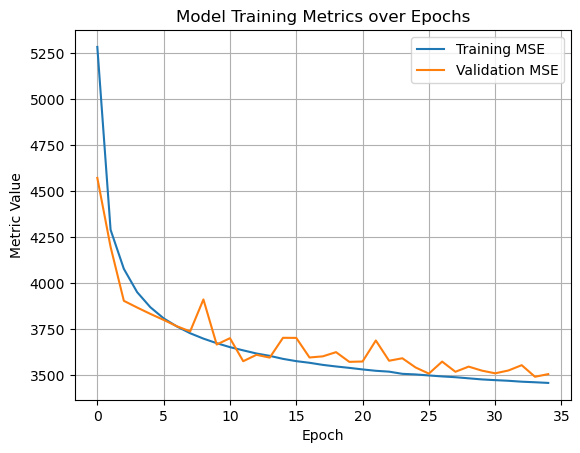

In [16]:
plt.plot(history.history["mse"], label="Training MSE")
plt.plot(history.history["val_mse"], label="Validation MSE")


plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.grid()
plt.title("Model Training Metrics over Epochs")
plt.legend(loc="best")

plt.show()

In [17]:
Y_pred = model.predict(X_test)
Y_pred = Y_pred.reshape(
    Y_pred.shape[0],
)

9951/9951 [==============================] - 12s 1ms/step


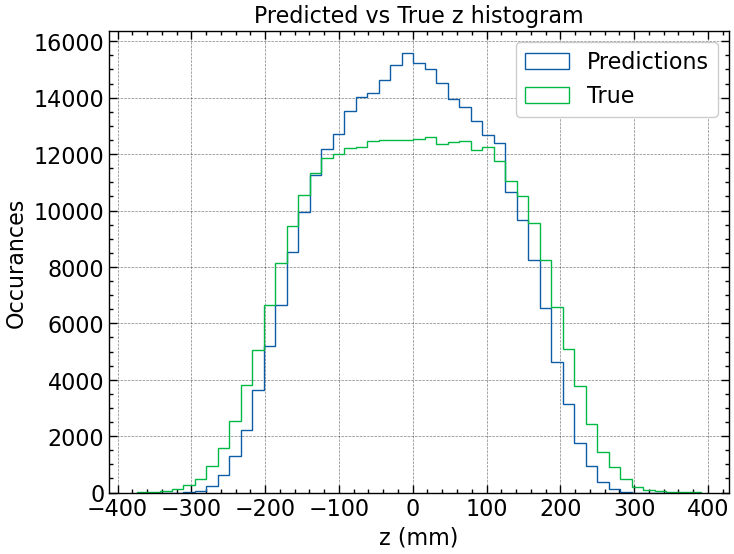

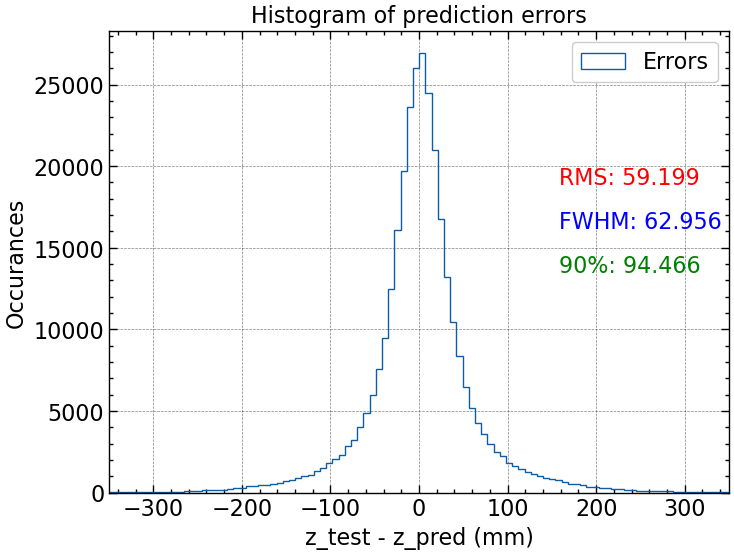

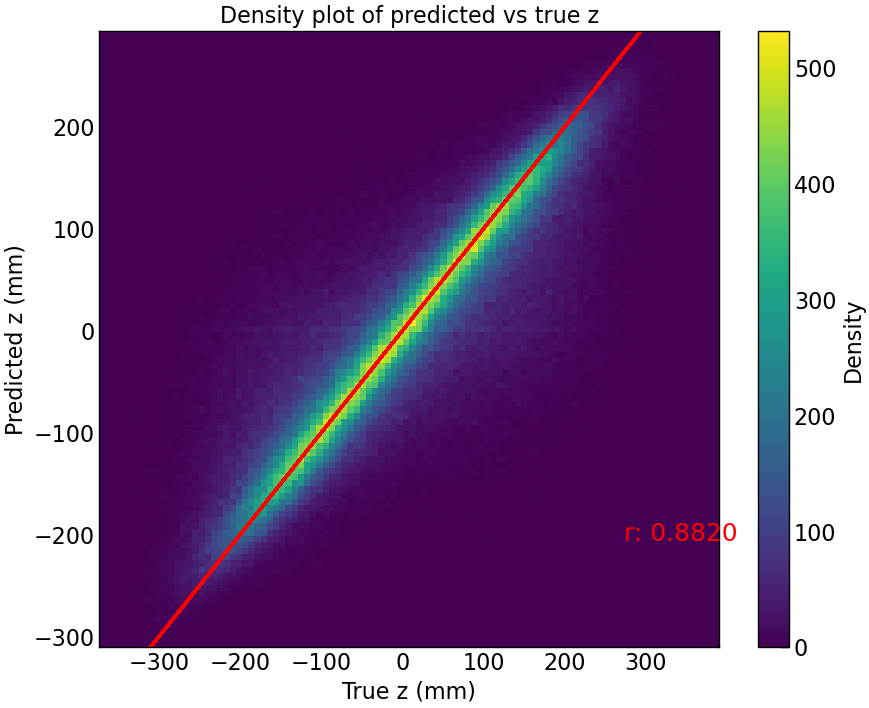

In [18]:
utils.plot_predictions(Y_test, Y_pred)
utils.plot_errors(Y_test, Y_pred, xmax=350, xcut=350, binnum=100)
utils.plot_corelation(Y_test, Y_pred, density=True, log_density=False, plot_line=True)

In [28]:
X_train.shape

(1273724, 22)

In [34]:
feature_names = [
    "psb eta",
    "emb1 eta",
    "emb2 eta",
    "emb3 eta",
    "hab1 eta",
    "psb - emb1 eta",
    "emb1 - emb2 eta",
    "emb2 - emb3 eta",
    "emb3 - hab1 eta",
    "psb(4)",
    "psb(5) - psb(3)",
    "emb1(8)",
    "emb1(9) - emb1(7)",
    "emb1(10) - emb1(6)",
    "emb1(11) - emb1(5)",
    "emb1(12) - emb1(4)",
    "emb2(4)",
    "emb2(5) - emb2(3)",
    "emb3(4)",
    "emb3(5) - emb3(3)",
    "hab1(4)",
    "hab1(5) - hab1(3)",
]

In [30]:
len(feature_names)

22

In [40]:
feature_names = [
    "psb eta",
    "emb1 eta",
    "emb2 eta",
    "emb3 eta",
    "hab1 eta",
    "psb - emb1 eta",
    "emb1 - emb2 eta",
    "emb2 - emb3 eta",
    "emb3 - hab1 eta",
    "psb(4)",
    "psb(5) - psb(3)",
    "emb1(8)",
    "emb1(9) - emb1(7)",
    "emb1(10) - emb1(6)",
    "emb1(11) - emb1(5)",
    "emb1(12) - emb1(4)",
    "emb2(4)",
    "emb2(5) - emb2(3)",
    "emb3(4)",
    "emb3(5) - emb3(3)",
    "hab1(4)",
    "hab1(5) - hab1(3)",
]

# Step 1: Create a SHAP explainer for your Keras model
explainer = shap.DeepExplainer(
    model, X_train[:1000]
)  # Adjust the data size as per your needs

# Step 2: Calculate SHAP values
shap_values = explainer.shap_values(
    X_train[:1000]
)  # Adjust the data size as per your needs

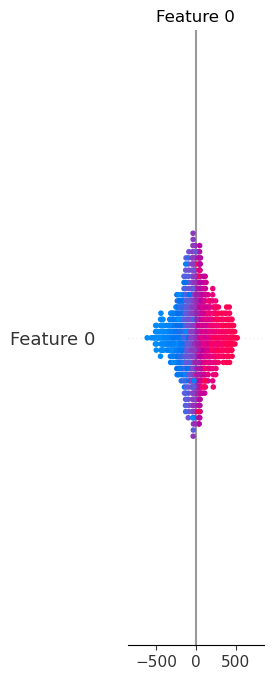

In [49]:
# Step 3: Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train[:1000], plot_type="dot")

In [42]:
X_train.shape

(1273724, 22)

In [44]:
shap_values.shape

(1000, 22, 1)

In [46]:
X_train[:1000].shape

(1000, 22)

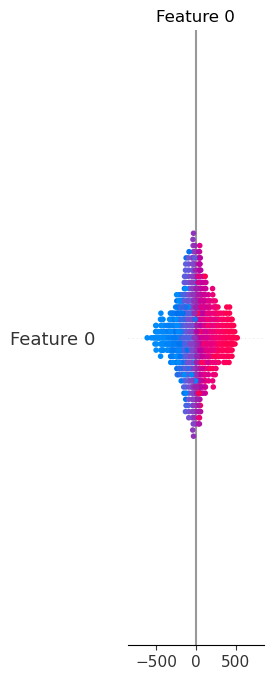

In [54]:
shap.summary_plot(shap_values[:1000, :], X_train[:1000, :])